In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")

In [2]:
from priors import PriorSet, UP, NP, JP
import tf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 206318379.
('Transitmask:', array([], dtype=int64))
Using *GP* to flatten (can be 'GP', 'Median', or default to SavGol)
there can still be leftover bad points, so sigma clipping is recommended
Also might be good to rerun with transitmask set
WARNING [astropy._showwarning()]: Input data contains invalid values (NaNs or infs), which were automatically masked.


/Users/Sophie/anaconda2/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/Sophie/anaconda2/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


3386
3330
Using period range [  1.  50.]
Overwriting: df= [  9.80000000e-05] fmin= 0.02 freq_range [ 0.02  1.  ]
Computing bls...
=====Results====
Best period: 2.26050002261
Best freq: 0.44238
Depth: 0.00431379865711
Epoch: 2144.99202232
Number of transits: 30
Optimization terminated successfully.
('Per=', 2.2604373106175024, 'epoch=', 2144.9902420830567)


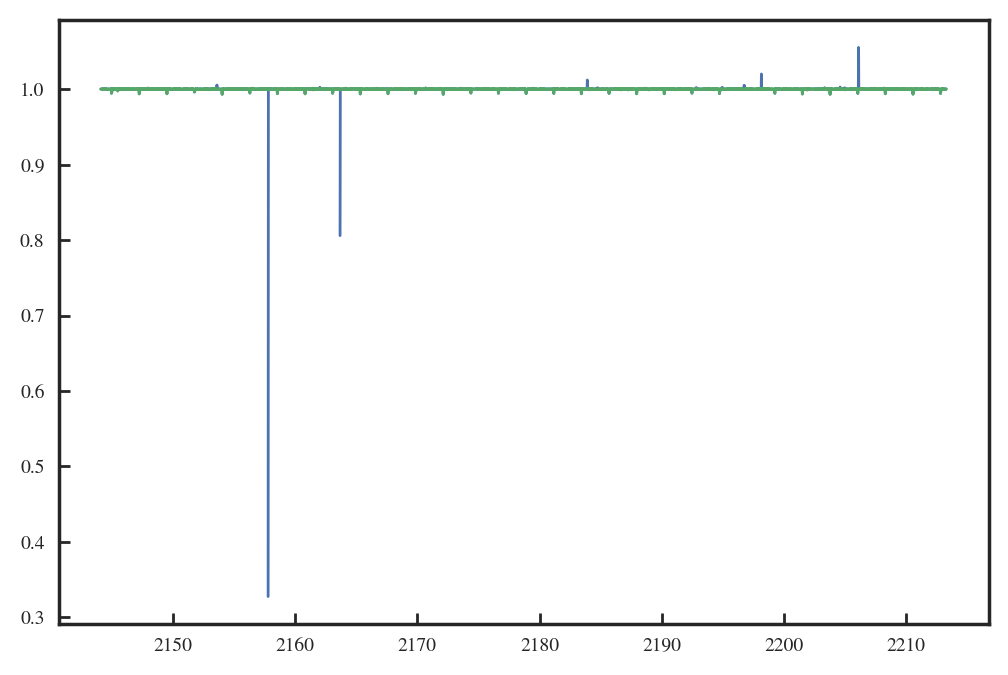

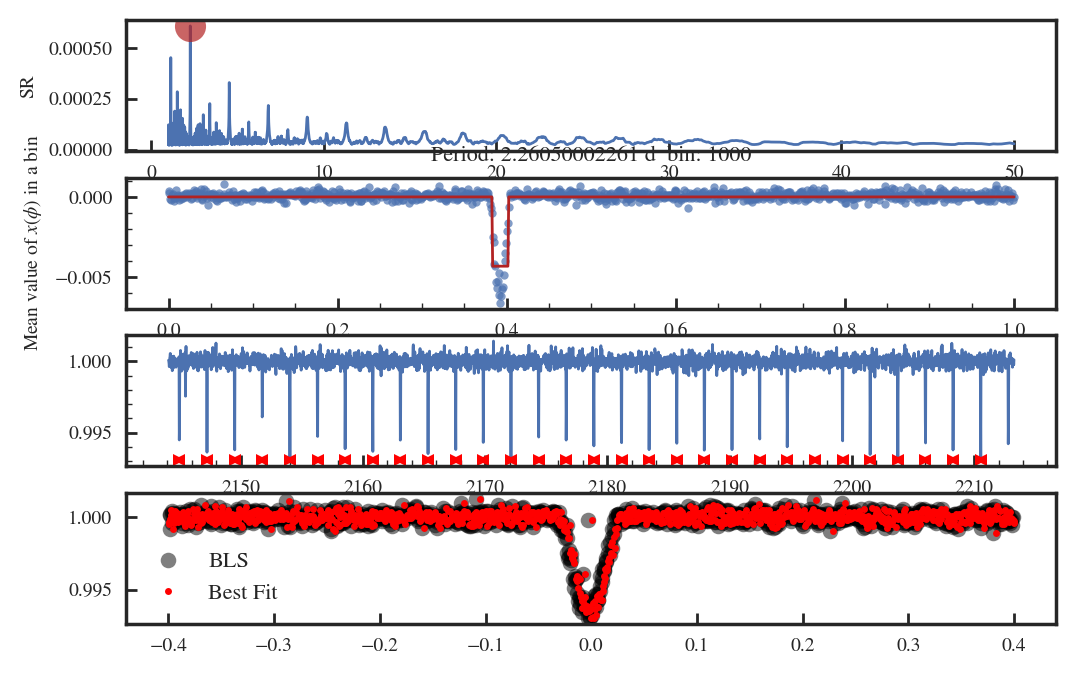

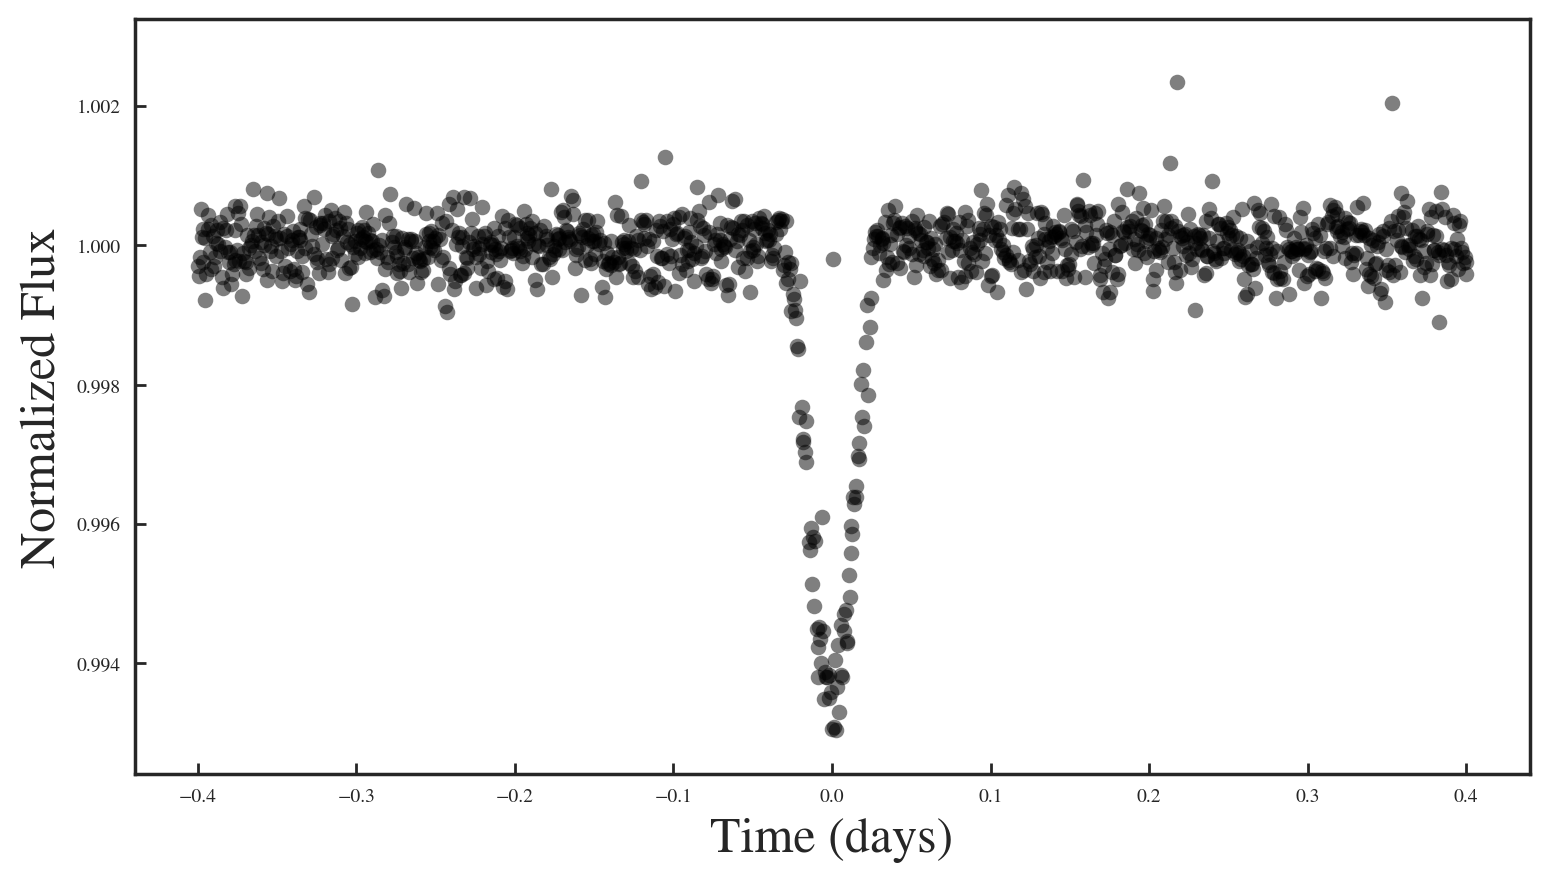

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 206318379.
('Transitmask:', array([1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 2584, 2585,
       2586, 2587, 2588, 2589, 2590, 2591, 2592,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48, 1588, 1589, 1590, 1591, 1592,
       1593, 1594, 1595, 1596, 1597, 3137, 3138, 3139, 3140, 3141, 3142,
       3143, 3144, 3145, 3146,  592,  593,  594,  595,  596,  597,  598,
        599,  600,  601, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148,
       2149, 2150, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153,
       1154, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703,
        150,  151,  152,  153,  154,  155,  156,  157,  158, 1699, 1700,
       1701, 1702, 1703, 1704, 1705, 1706, 1707, 3247, 3248, 3249, 3250,
       3251, 3252, 3253, 3254, 3255, 3256,  703,  704,  705,  706,  707,
        708,  709,  710,  711,  712, 2252, 2253, 2254, 22

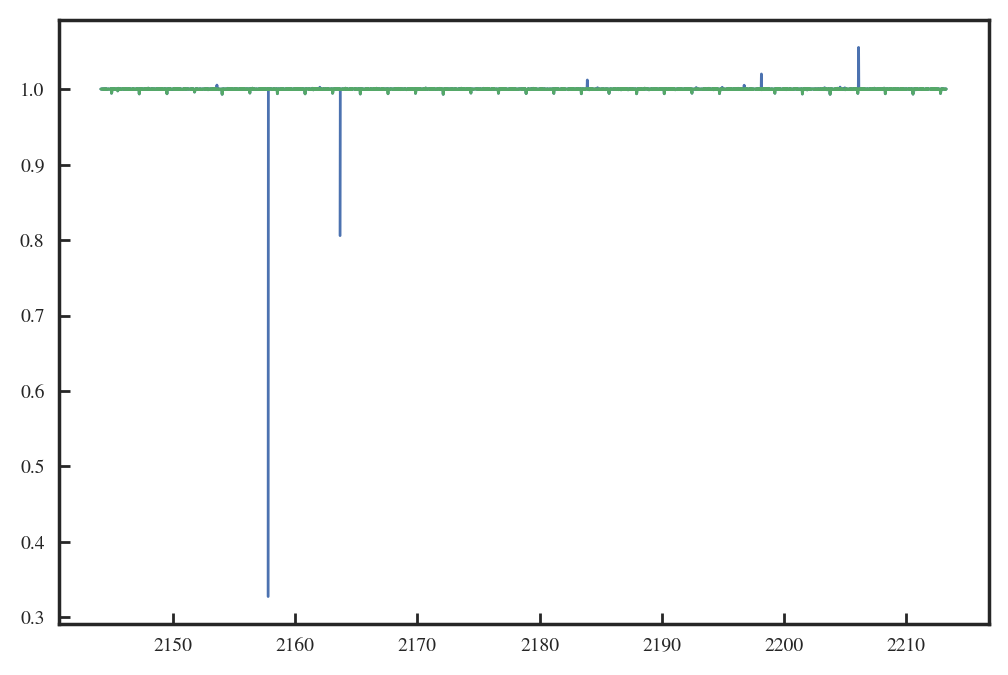

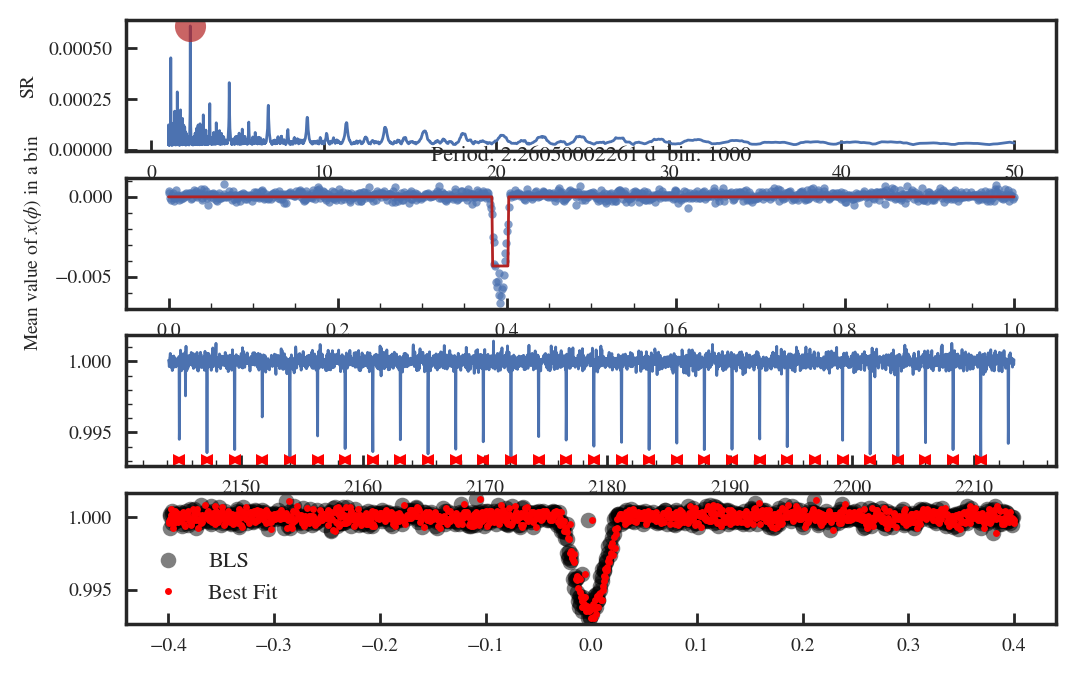

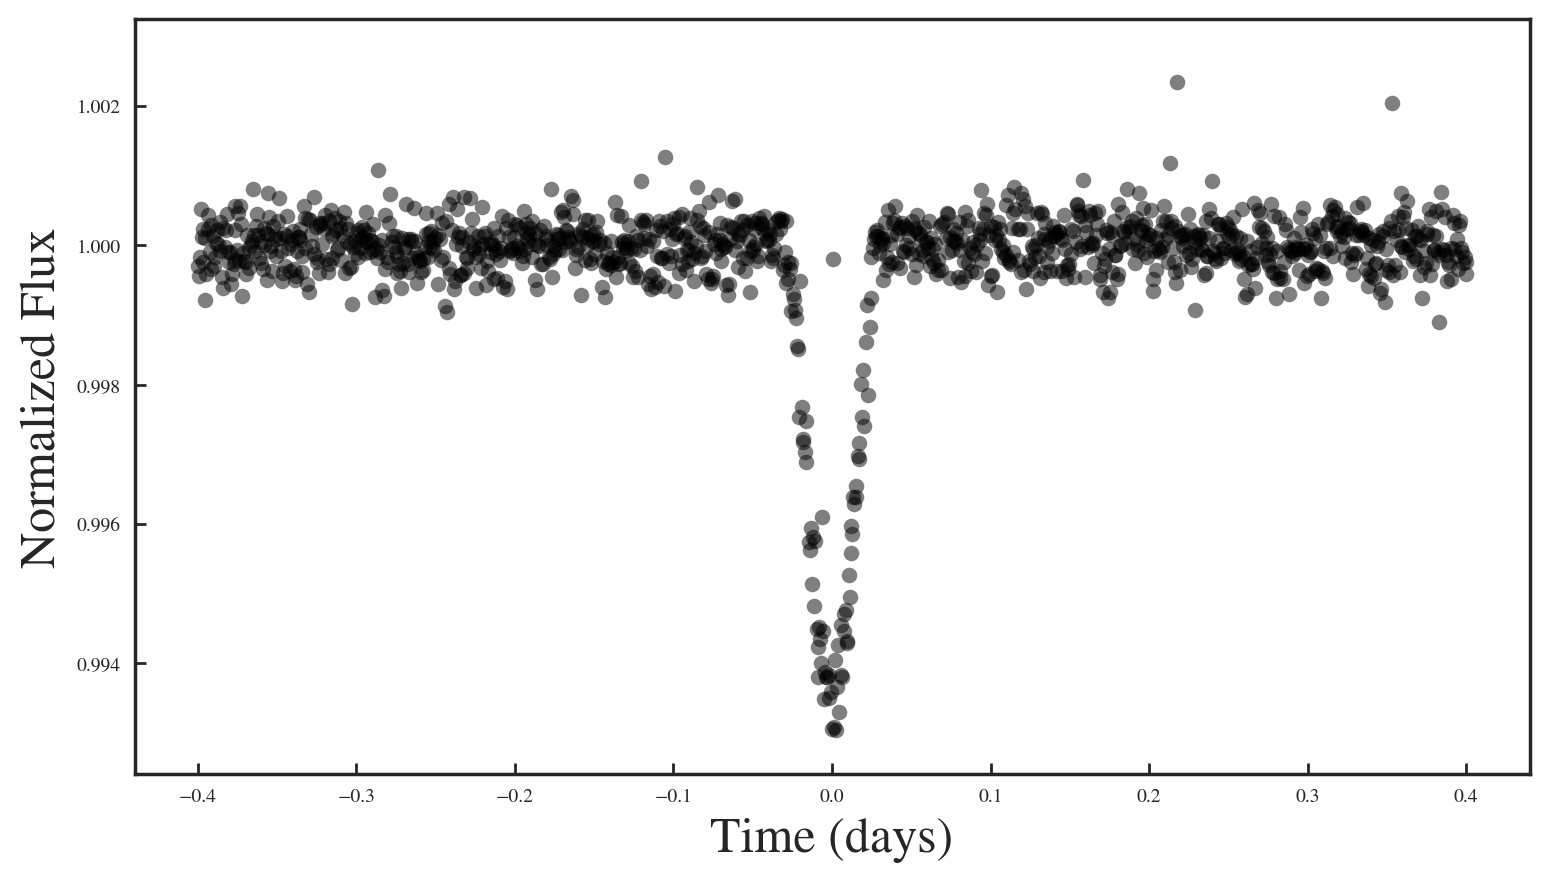

In [3]:
DUR = 0.2
EP =epicblsmulti.EVERESTBLS(206318379,sigma=15,sigma_upper=2.,flatten_method="GP")
planet = EP(dur=DUR)
EP =epicblsmulti.EVERESTBLS(206318379,sigma=15,sigma_upper=2.,flatten_method="GP",transitmask=EP.star.transitmask)
planet = EP(dur=DUR)

('Using planet with t0=', 2144.9902393533848, 'and P=', 2.2604372081577928)
Using median filtered data -- assumes you have run that from beginning!


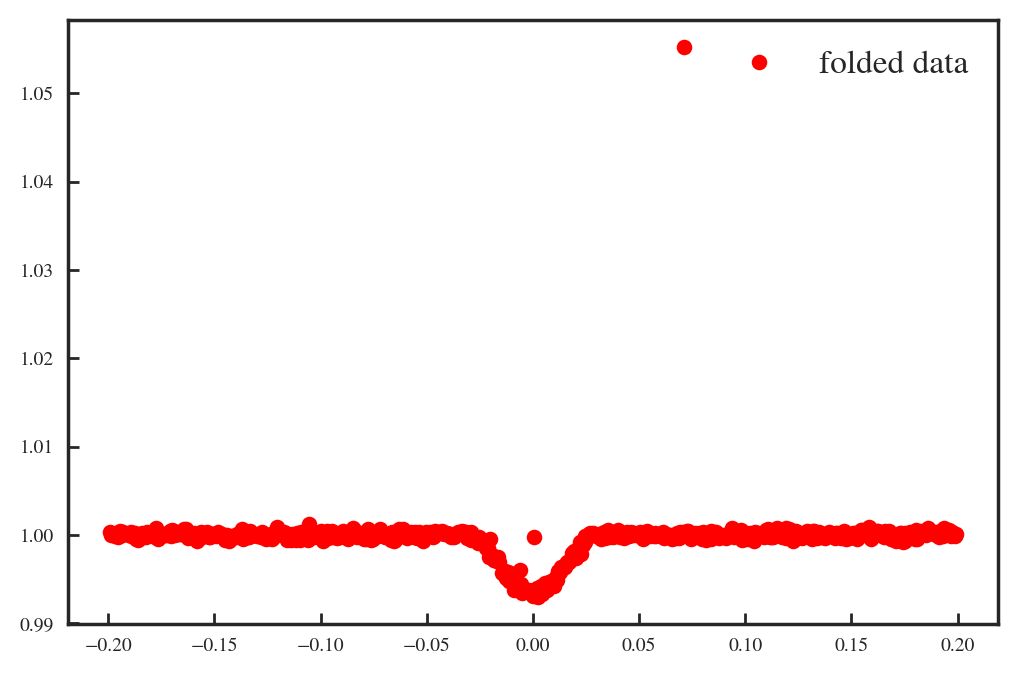

In [4]:
df = EP.get_cutout_phased_df(dur=0.4,sigma=None)
df = df.reset_index(drop=True)
df= df.sort_values("x")

595
[269 289 299 403]
591


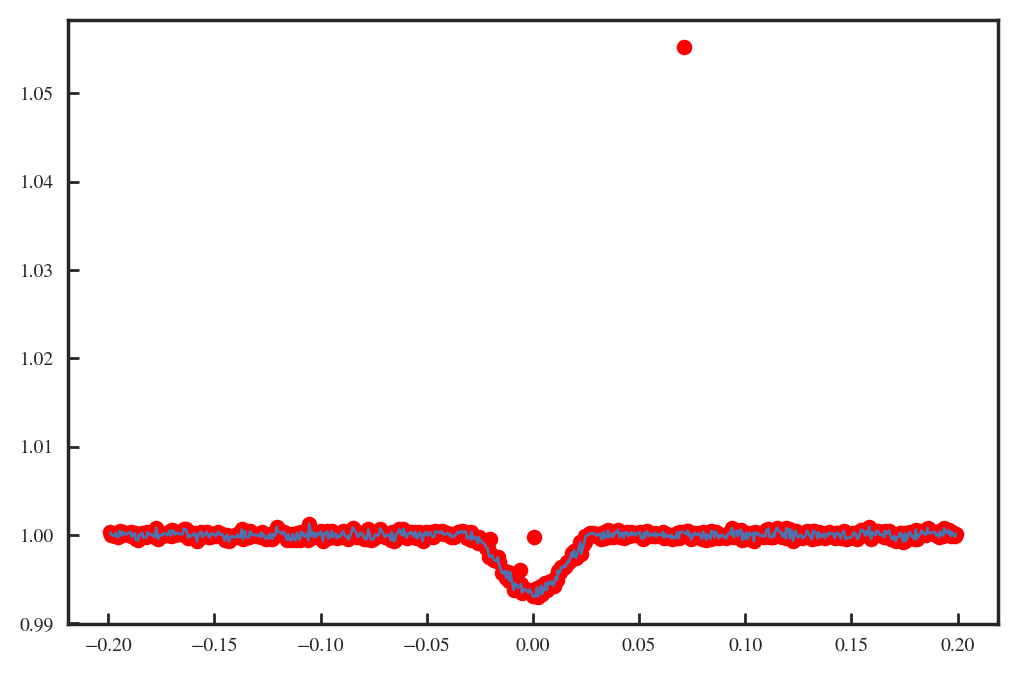

In [5]:
t,f,m,mm = k2help.median_filter_and_sigma_clip(df.x.values,df.y.values,return_mask=True,sigma=4.)
print(len(df))
print(m)
plt.plot(df.x, df.y,"r.")
dfmm= df.drop(m)
t_fold_final = dfmm.x
f_fold_final = dfmm.y
plt.plot(dfmm.x,dfmm.y)
print(len(dfmm))

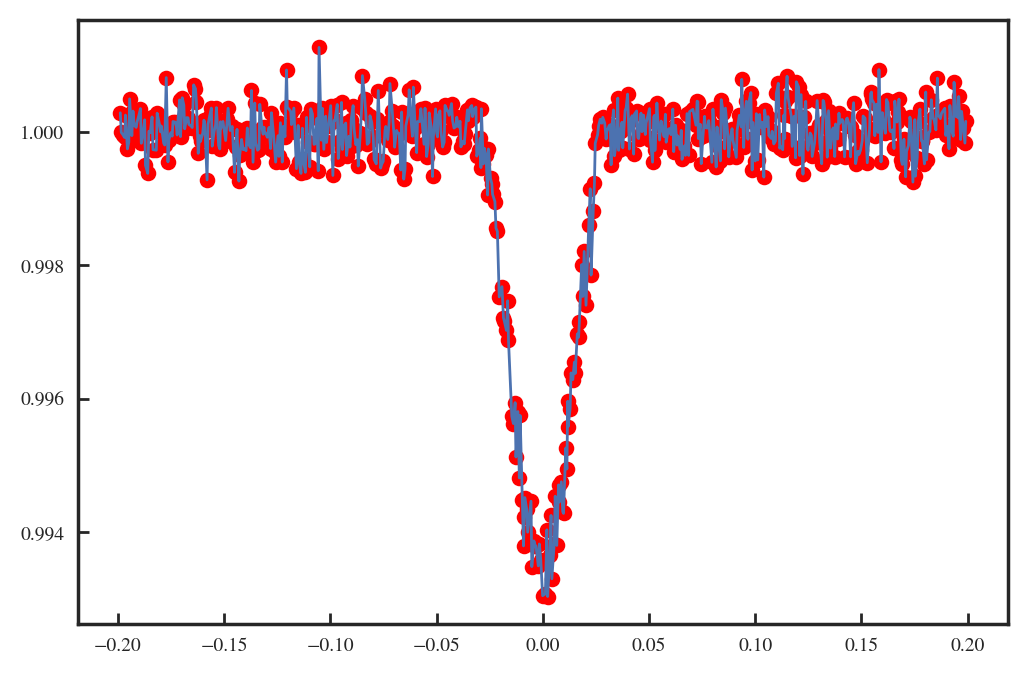

In [6]:
dfmm_s = dfmm.sort_index()
dfmm_s["time"] = dfmm_s.time.values + k2help.KEPLER_JD_OFFSET
plt.plot(dfmm_s.x,dfmm_s.y,"r.")
plt.plot(dfmm.x,dfmm.y)

In [12]:
dfmm_s.to_csv("../data/k2_28b/K2_data_k2_28b_final.csv")

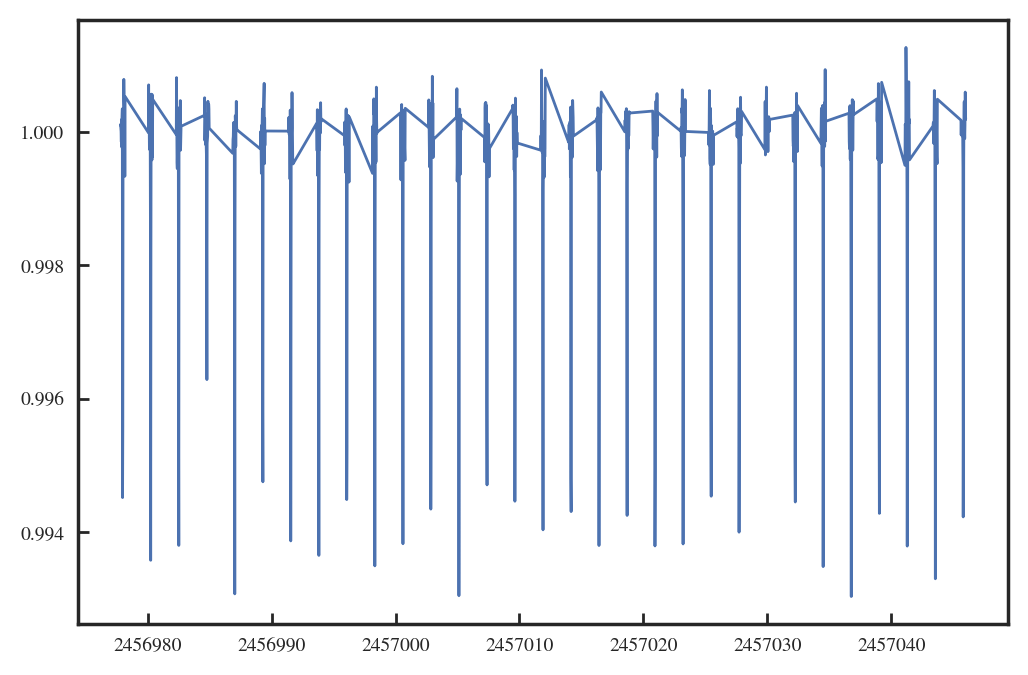

In [7]:
dfmm_s = dfmm_s.sort_values("index")
plt.plot(dfmm_s.time,dfmm_s.y)

In [8]:
import utils
_t0   = planet.get_attributeAndError("_pl_tranmid")[0]
ii   = planet.get_attributeAndError("_pl_orbincl")[0:2]
pp   = planet.get_attributeAndError("_pl_orbper")[0:2]
rprs = planet.get_attributeAndError("_pl_ratror")[0:2]
aRs  = planet.get_attributeAndError("_pl_ratdor")[0:2]

_p = np.log10(pp[0])
print("log(P)",mcmc_utils.err_logP_from_p(pp))
print("cos(i)",mcmc_utils.err_cosi_from_i(ii))
print("RpRs",rprs)
print("log(aRs)",mcmc_utils.err_logaRs_from_aRs(aRs))
print(_p)
print(_t0)

log(P) [0.35419244743342332, nan]
cos(i) [0.0054326847987868424, nan]
RpRs (0.074465214304415425, nan)
log(aRs) [1.3168087280927998, nan]
0.354192447433
2456977.99024


In [9]:
class LPFunction(object):
    """
    Log-Likelihood function class
    
    General philosophy:
    — Modify this for each fit
    — Outputs will be passed to emcee.sampler()
    — Outside of this are functions to plot the MCMC chains and corner plots
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    
    I extended the Prior and Priorset classes in 
    /Users/gks/.local/lib/python2.7/site-packages/exotk
    """
    def __init__(self):
        """
        Note: number_pv_baseline must be set to whatever the index of the 'fraw' parameter is
        """
        # This is only performed during initialization
        self.data= {"time"   : dfmm_s.time.values,  # phase folded time in days (centered on 0)
                    "flux"   : dfmm_s.y.values   # phase folded flux
                    }
        
        #####
        # Setting priors
        self.priors = [UP( _t0 -0.01           , _t0+0.01               , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   0 - Transit centre, Tc
                       UP( _p  -0.001          , _p +0.001              , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   1 - log(P)
                       UP( 0.                  , 0.2                    , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   2 - cos(i)
                       UP( 0.0                 , 0.1                    , 'RpRs'     ,r'$R_p/R_s$'             ,priortype="model"),  ##   3 - rp/rstar
                       UP( 0.9                 , 2.0                    , 'log(a/Rs)',r'$\log(a/R_s)$'         ,priortype="model"),  ##   4 - log(a/rstar)     
                       #UP( 0.                  , 1.                     , 'q1'       ,r'$q_1$'                 ,priortype="model"),  ##   5 - q1
                       #UP( 0.                  , 1.                     , 'q2'       ,r'$q_2$'                 ,priortype="model"),  ##   6 - q2
                       UP( 0.9                 , 1.1                    , 'fraw'     ,r'fraw'                  ,priortype="baseline"),  ##   7 - Baseline constant
                       UP( 1e-5                , 50e-5                  , 'err'      ,r'error'                 ,priortype="error")]  ##   8 - Baseline constant
        
        # If we want to fix limb-dark parameters
        self.limbdark = [0.42662803,0.30760637]#[ 0.16689202, 0.44493439] 
        self.ps     = PriorSet(self.priors)
        self.number_pv_baseline = np.where(np.array(self.ps.priortypes)=="baseline")[0][0]
        self.number_pv_error = np.where(np.array(self.ps.priortypes)=="error")[0][0]
        print("Baseline is at pv=",self.number_pv_baseline)
        print("Error is at pv=",self.number_pv_error)
        
    def compute_transit(self,pv,times=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        self.params = batman.TransitParams()
        self.params.t0 = pv[0]
        self.params.per = 10.**pv[1]
        self.params.inc = np.arccos(pv[2])*180./math.pi
        self.params.rp = pv[3]
        self.params.a = 10.**pv[4]
        self.params.ecc = 0.
        self.params.w = 0.
        q1, q2 = pv[5], pv[6]
        self.params.u = mcmc_utils.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        #self.params.u = self.limbdark
        self.params.limb_dark = "quadratic"
        self.params.fp = 0.001
        if times==None:
            times = self.data["time"]        
        transitmodel = batman.TransitModel(self.params, times, transittype='primary',supersample_factor=7,exp_time=0.020431801470066003)
        self.lc = transitmodel.light_curve(self.params)
        return self.lc        
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
        pv    - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            #print(i)
            detrend += pv[i]*(self.data[self.ps.labels[i]]-1.)
        return detrend/pv[self.number_pv_baseline]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
        pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        The full light curve model with a trend
        
        TODO:
        - Choose to use GPs ?
        """
        return self.compute_transit(pv) + self.detrend(pv)
    
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        
        NOTES:
        This is done each time an instance is called
        """
        # If priors are outside of bounds, return -inf
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -np.inf
        flux_m = self.compute_lc_model(pv)
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        scaled_flux   = self.data["flux"]/pv[self.number_pv_baseline]
        log_of_model  = ll_normal_es(scaled_flux, flux_m, pv[self.number_pv_error])
        log_ln = log_of_priors + log_of_model
        return log_ln

In [12]:
#reload(tf)
import trf
TF = trf.TransitFit(LPFunction)

Baseline is at pv= 5
Error is at pv= 6


In [13]:
TF.minimize_PyDE(mcmc=False)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv  center_dist
0         tc  2.456978e+06  2.456978e+06  2.456978e+06  2.456978e+06     0.000265
1       logP  3.541924e-01  3.531924e-01  3.551924e-01  3.541936e-01    -0.000001
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  2.250381e-02     0.077496
3       RpRs  5.000000e-02  0.000000e+00  1.000000e-01  7.568967e-02    -0.025690
4  log(a/Rs)  1.450000e+00  9.000000e-01  2.000000e+00  1.269947e+00     0.180053
5       fraw  1.000000e+00  9.000000e-01  1.100000e+00  1.000051e+00    -0.000051
6        err  2.550000e-04  1.000000e-05  5.000000e-04  3.281177e-04    -0.000073
LogLn value: -3917.15719766
Log priors 23.1738870311


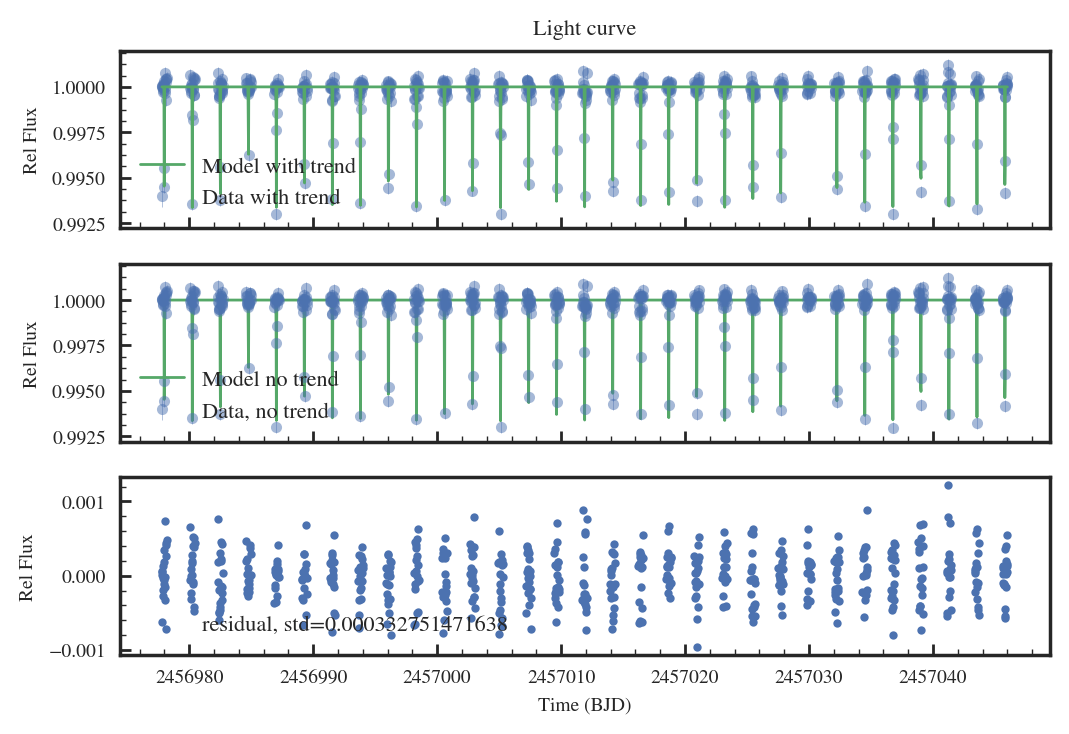

In [14]:
TF.plot_lc_fit()

In [15]:
TF.minimize_PyDE(mcmc=True,mc_iter=2000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv   center_dist
0         tc  2.456978e+06  2.456978e+06  2.456978e+06  2.456978e+06  2.495437e-04
1       logP  3.541924e-01  3.531924e-01  3.551924e-01  3.541927e-01 -2.285588e-07
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  2.608125e-02  7.391875e-02
3       RpRs  5.000000e-02  0.000000e+00  1.000000e-01  7.596630e-02 -2.596630e-02
4  log(a/Rs)  1.450000e+00  9.000000e-01  2.000000e+00  1.255934e+00  1.940663e-01
5       fraw  1.000000e+00  9.000000e-01  1.100000e+00  1.000044e+00 -4.443148e-05
6        err  2.550000e-04  1.000000e-05  5.000000e-04  3.319571e-04 -7.695709e-05
LogLn value: -3917.5245417
Log priors 23.1738870311
Running MCMC
MCMC iterations= 2000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65

Plotting chains


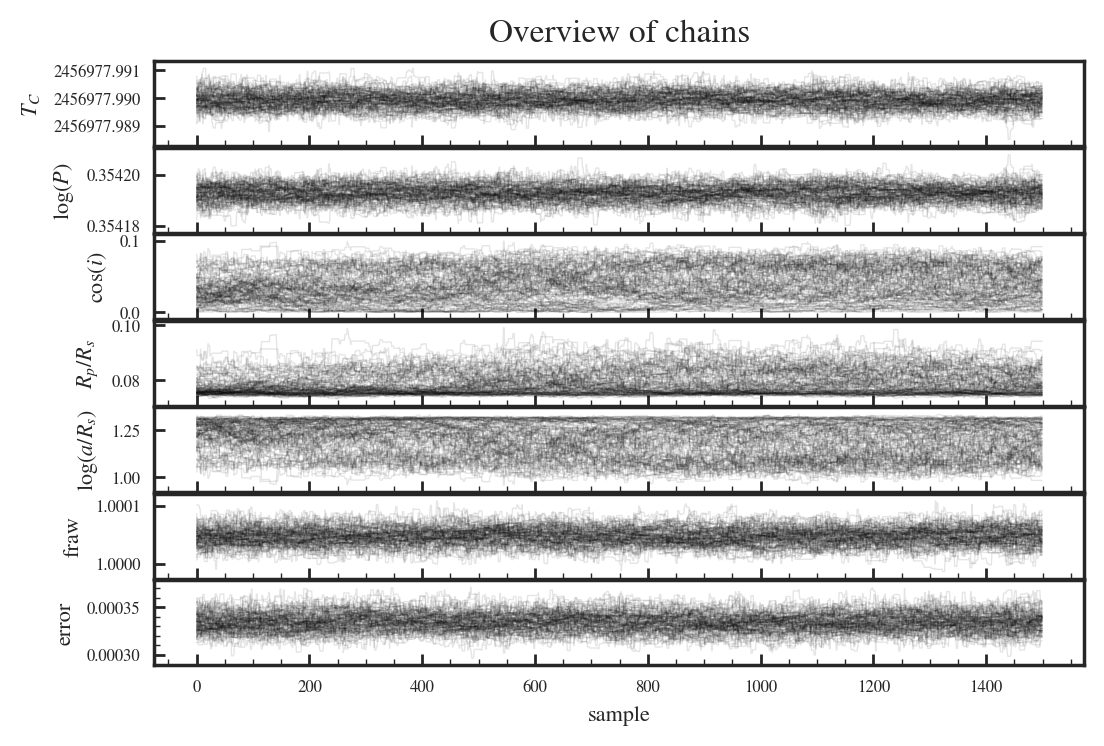

In [24]:
TF.plot_chains(burn=500)

In [25]:
TF.gelman_rubin(burn=500)

array([ 1.06538691,  1.07064694,  1.30358553,  1.2260007 ,  1.27228316,
        1.07002011,  1.07991863])

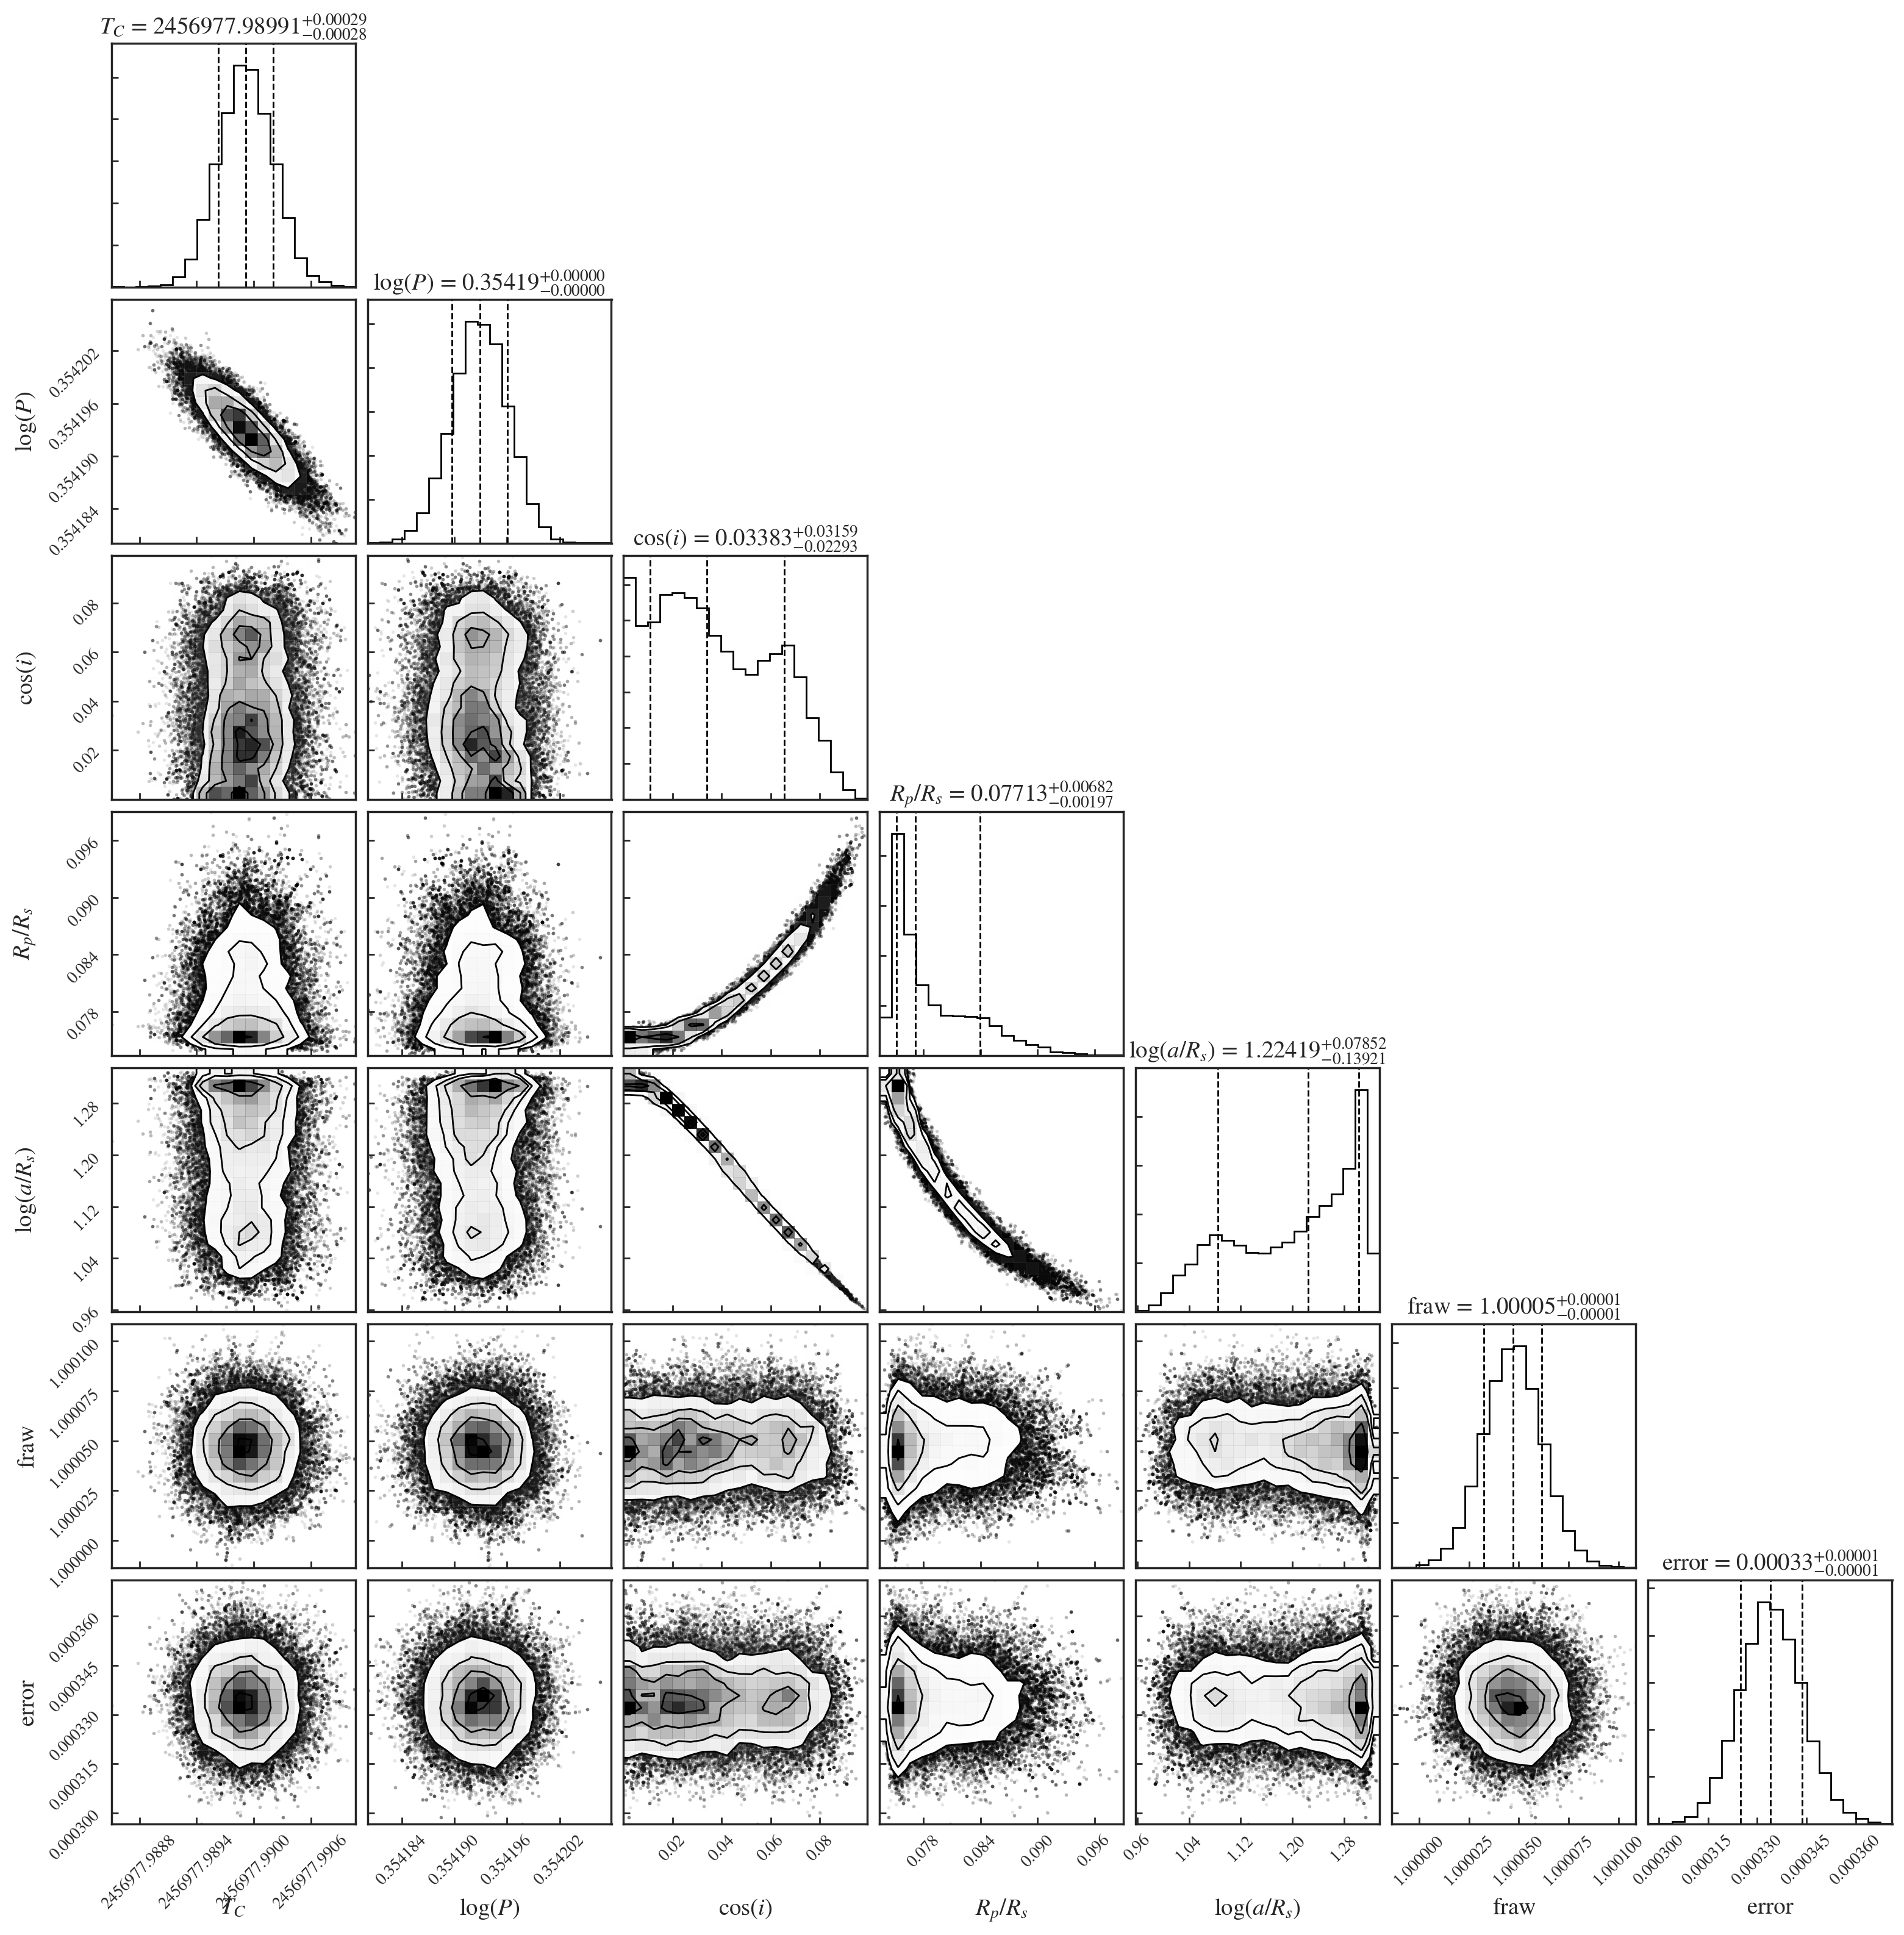

In [26]:
TF.plot_corner(show_titles=True,burn=500)

In [27]:
df_param = TF.get_transit_parameters(burn=500,thin=1,st_rad=0.288,st_raderr1=0.028,st_teff=3214.,st_teff_err1=60.,rho_instead_of_aRs=False)
df_param

Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3
0.354196218107
2.26045683403
ASSUMING aRs IS JUMP PARAMETER pv[4]
18


medvals      minus       plus                                 values  \
0   2.456978e+06   0.000284   0.000287  $2456977.98991_{-0.00028}^{+0.00029}$   
1   2.260440e+00   0.000017   0.000016        $2.26044_{-0.00002}^{+0.00002}$   
2   7.712986e-02   0.001974   0.006821           $0.0771_{-0.0020}^{+0.0068}$   
3   2.466636e+00   0.258626   0.284584                 $2.47_{-0.26}^{+0.28}$   
4   2.200589e-01   0.023073   0.025389               $0.22_{-0.023}^{+0.025}$   
5   5.949016e-03   0.000301   0.001099         $0.00595_{-0.00030}^{+0.0011}$   
6   1.675693e+01   4.595609   3.320633                   $16.8_{-4.6}^{+3.3}$   
7   2.201760e-02   0.005848   0.005057            $0.022_{-0.0058}^{+0.0051}$   
8   1.742046e+01  10.761421  12.543749                 $17.0_{-11.0}^{+13.0}$   
9   8.806114e+01   1.812164   1.314026                   $88.1_{-1.8}^{+1.3}$   
10  5.664464e-01   0.347874   0.229679                 $0.57_{-0.35}^{+0.23}$   
11  0.000000e+00   0.000000   0.000000                    $0.0_{-0.0}^{+0.0}$   
12  0.000000e+00   0.000000   0.000000                    $0.0_{-0.0}^{+0.0}$   
13  3.889764e+02  33.271081  66.894134                $389.0_{-33.0}^{+67.0}$   
14  1.588770e+01   4.777305  14.085564                  $15.9_{-4.8}^{+14.0}$   
15  3.943686e-02   0.001753   0.004199           $0.0394_{-0.0018}^{+0.0042}$   
16  4.033191e-03   0.001274   0.004335            $0.004_{-0.0013}^{+0.0043}$   
17  2.456979e+06   0.000278   0.000280  $2456979.12013_{-0.00028}^{+0.00028}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

In [28]:
print(df_param.to_latex())

\begin{tabular}{lrrrlll}
\toprule
{} &       medvals &      minus &       plus &                                 values &                                             Labels &                           Description \\
\midrule
0  &  2.456978e+06 &   0.000284 &   0.000287 &  \$2456977.98991\_\{-0.00028\}\textasciicircum\{+0.00029\}\$ &                     \$T\_\{0\}\$ \$(\textbackslashmathrm\{BJD\_\{TDB\}\})\$ &                      Transit Midpoint \\
1  &  2.260440e+00 &   0.000017 &   0.000016 &        \$2.26044\_\{-0.00002\}\textasciicircum\{+0.00002\}\$ &                                         \$P\$ (days) &                        Orbital period \\
2  &  7.712986e-02 &   0.001974 &   0.006821 &           \$0.0771\_\{-0.0020\}\textasciicircum\{+0.0068\}\$ &                                          \$R\_p/R\_*\$ &                          Radius ratio \\
3  &  2.466636e+00 &   0.258626 &   0.284584 &                 \$2.47\_\{-0.26\}\textasciicircum\{+0.28\}\$ &                       

In [26]:
import numpy as np
import pandas as p
import pandas as pd
import astropy.constants as aconst
import astropy.units as u

def calc_logg_from_r_m(r,m):
    """
    INPUT:
    - r in solar radii
    - m in solar masses
    
    OUTPUT:
    - logg (log10(cgs gravity))
    """
    rad = r*aconst.R_sun.value
    mass = m*aconst.M_sun.value
    logg = np.log10((aconst.G.value*mass/(rad**2.))*100.)
    return logg


In [28]:
calc_logg_from_r_m(0.48,0.51)

4.7831553286498956